In [1]:
import geopandas as gpd
from scipy.spatial import KDTree
import numpy as np
from SimuSamp.functions.load.SpatDat import SpatDat
import pandas as pd
from SimuSamp.functions.compute.n_core_sampler import sample_n_cores

In [2]:
parent_filepath = "../../../../Simulated WS Sampling/block_data"

sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]

microns_per_pixel=0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

# Compute Simulated Cores from Whole-Slide Data

In [ ]:
for sampleid in sampleids:
    # Load sample data
    spatdat = SpatDat(sampleid, parent_filepath)

    results_list = []
    for region in ["tumour", "IM"]:
        # Perform simulated sampling
        result = sample_n_cores(spatdat, region=region)

        results_list.append(result)

    results = pd.concat(results_list)

    # Save results per sampleid
    results.to_excel(f"Data/{sampleid}_sim_results.xlsx", index=False)

    del(results_list, results)

In [ ]:
combined_df = pd.concat([pd.read_excel(f"../../../../Data/Simulated/{sampleid}_sim_results.xlsx") for sampleid in sampleids])

combined_df.to_excel("../../../../Data/Simulated/simulation_results.xlsx")

# Explore Simulated Data for Single Whole-Slide Specimen

In [3]:
combined_df = pd.read_excel("../../../../Data/Simulated/simulation_results.xlsx")

In [4]:
spatdat = SpatDat("01_F", parent_filepath)

In [5]:
# Get total cell df
cells = spatdat.subset_cells("extended_partition")

# Drop unnecessary columns
cells = cells.drop(columns=["Analysis Region", "CD8", "layer"])

# Get total tissue area
area = spatdat.subset_annotation("extended_partition")
area = gpd.GeoDataFrame(geometry=[area])

## E.g. Estimate Mean Nearest-Neighbour Distance in Small (0.3-radius) Cores

In [6]:
small_cores = combined_df[(combined_df["sampleid"] == "01_F") & (combined_df["n_sampled"] == 10) & (combined_df["core_radius"] == 0.3)].iloc[[0], :]

In [7]:
from shapely.wkt import loads

In [8]:
cores = loads(small_cores["cores"].iloc[0])
cores = gpd.GeoDataFrame(geometry=[x for x in cores.geoms])

inter_cells = cells.sjoin(cores, predicate="within")

core_cells_0 = inter_cells[inter_cells["index_right"] == 2].reset_index(drop=True)

core_0 = cores.iloc[[2], :]

In [68]:
distance = 5000 * microns_per_pixel

In [9]:
def edge_correction_weight(point, core, distance):
    # Get fraction of the buffer within the analysis area
    circle = point.buffer(distance)
    intersected_area = circle.intersection(core).area

    weight = circle.area / intersected_area
    
    return weight

In [40]:
def compute_nn_per_point(cell_gdf, core, distance=500 / microns_per_pixel):

    nn_values = []

    tree = KDTree([[p.x, p.y] for p in cell_gdf.geometry])

    for point in cell_gdf.geometry:
        dists, _ = tree.query([point.x, point.y], k=len(cell_gdf), distance_upper_bound=distance)
        # Exclude self-distance
        dists = dists[np.isfinite(dists) & (dists > 0)]
        
        count = np.sum(dists <= distance)

        # Apply edge correction
        weight = edge_correction_weight(point, core, distance)

        nn_values.append(count / np.sqrt(weight))
    
    mean_nn = np.mean(nn_values) * microns_per_pixel

    return mean_nn

In [43]:
points = []
radii = []

for r in [75, 150, 300, 450, 600, 750, 900, 1000, 1200, 1500, 2000]:
    nn = compute_nn_per_point(core_cells_0, core_0, distance=r / microns_per_pixel)
    points.append(nn)
    radii.append(r)

In [31]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Mean NN Distance (microns)')

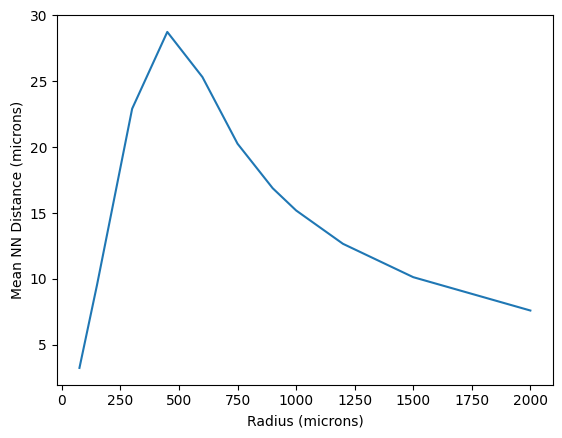

In [45]:
plt.plot(radii, points)

plt.xlabel("Radius (microns)")

plt.ylabel("Mean NN Distance (microns)")

# plt.ylim(0, 20)

In [41]:
nn_res = compute_nn_per_point(core_cells_0, core_0, distance=300/microns_per_pixel)

In [42]:
nn_res

22.920258902023917